In [1]:
## Import Relavent libraries
import numpy as np

In [2]:
class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [3]:
## Initilize DecisionTreeClassifier Object
class DecisionTreeClassifier:
    
    ## Define Hyperparamaters
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        
        
    ## Finding the best Threshold, Feature pair for each node
    ## We need the data X and classification labels y. 
    def _best_split(self, X, y):
        
        ## Base case where a node has only one element, 
        m = y.size
        if (m == 1):
            return None, None
        
        ## Extract the number of obseravations in current data with classification calss as index
        ## in the current node. 
        num_current = [np.sum(y == c) for c in range(self.n_classes_)]
        
        ## Gini of current node.
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_current)
        
        ## Initilize feature threshold pair
        best_feat, best_thr = None, None
        
        ## Looping through each feature
        for feat in range(self.n_features_):
            
            # ReSort data along the current feature.
            observations, classification = zip(*sorted(zip(X[:, feat], y)))
            
            
            ## initilize the split count. These are arrays with 
            ## totals for each classification label. Left split starts at zero
            ## Right split starts with all the data. We compute information gain iterativly by 
            ## moving an observation from  right to left and then computing the gini index. 
            
            num_left = [0] * self.n_classes_
            num_right = num_current.copy()
            
            ## Looping through each threshold(observation)
            for i in range(1, m): 
                ## Pulling the ith observation's classification
                c = classification[i-1]
                ## Moving that observation to the other side of the split
                num_left[c] += 1
                num_right[c] -= 1
                
                ## Computing the Gini index of both sides 
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                
                ## Compute the Gini index of the cadidate split
                gini = (i * gini_left + (m - i) * gini_right) / m
                                
                    
                ## Continue in for loop if current observation is the same as previous.
                if observations[i] == observations[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_feat = feat
                    best_thr = (observations[i] + observations[i - 1]) / 2  # midpoint

        return best_feat, best_thr
    
    
    #################################################################################
    
    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

        
    def _grow_tree(self, X, y, depth=0):
        ## Pull the number of samples per class i.e class frequency histogram
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        ## The predicted class is the majority. 
        predicted_class = np.argmax(num_samples_per_class)
        
        ## Initialize Node object
        node = Node(predicted_class=predicted_class)
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

        
    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _predict(self, inputs):
        """Predict class for a single sample."""
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [4]:
import sys
from sklearn.datasets import load_iris
dataset = load_iris()
X, y = dataset.data, dataset.target  # pylint: disable=no-member
X = X[:,0:2].reshape((len(X[:,1]),2))
X[:,0] = (X[:,0] - np.min(X[:,0]))/(np.max(X[:,0]) - np.min(X[:,0]))
X[:,1] = (X[:,1] - np.min(X[:,1]))/(np.max(X[:,1]) - np.min(X[:,1]))


clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)


In [5]:
from graphviz import Digraph

In [34]:
def visualize_tree(tree):
    def add_nodes_edges(tree, dot=None):
        # Create Digraph object
        if dot is None:
            dot = Digraph()
            dot.node(name=str(tree), label=str(tree.predicted_class))

        # Add nodes
        if tree.left:
            dot.node(name=str(tree.left) ,label= str(str(tree.left.predicted_class)+ ' ' + str(tree.left.threshold)+ ' ' + str(tree.left.feature_index)))
            dot.edge(str(tree), str(tree.left))
            dot = add_nodes_edges(tree.left, dot=dot)
            
        if tree.right:
            dot.node(name=str(tree.right) ,label=str(str(tree.right.predicted_class)+ ' ' + str(tree.right.threshold)+ ' ' + str(tree.right.feature_index)))
            dot.edge(str(tree), str(tree.right))
            dot = add_nodes_edges(tree.right, dot=dot)

        return dot
    
    # Add nodes recursively and create a list of edges
    dot = add_nodes_edges(tree)

    # Visualize the graph
    display(dot)
    
    return dot

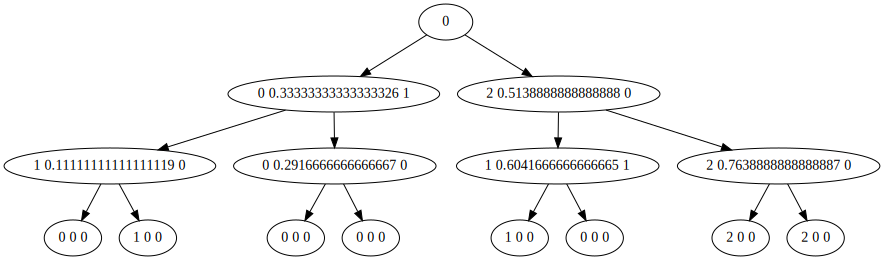

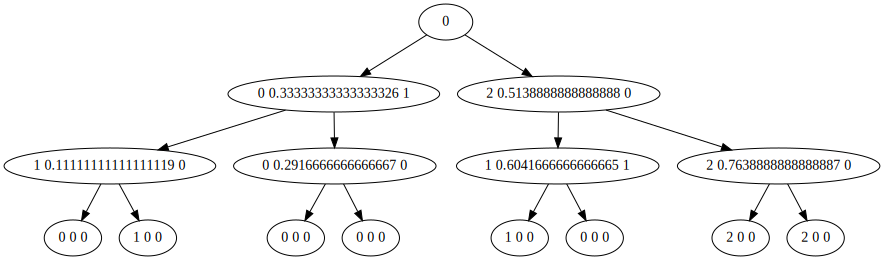

In [35]:
visualize_tree(clf.tree_)

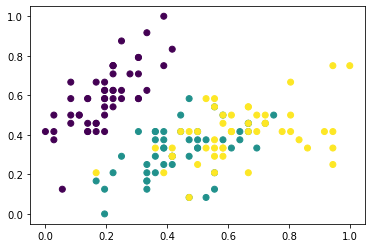

In [8]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y)

In [27]:
res = 100*100
xcoord = []
ycoord = []
prediction = []

In [28]:
for i in range(100):
    for j in range(100):
        xcoord.append(i/100)
        ycoord.append(j/100)
        prediction.append(clf.predict([[i/100, j/100]]))

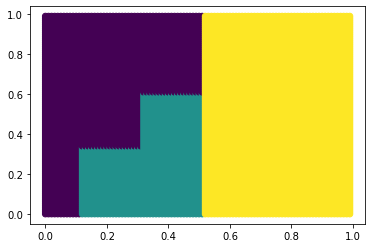

In [29]:
plt.scatter(xcoord, ycoord, c=prediction)